In [1]:
from IPython.display import FileLink

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(DESeq2)
library(phyloseq)
library(plyr); library(dplyr)
library(ggplot2)
library(doParallel)
library(foreach)
library(reshape)
library(RColorBrewer)
library(gridExtra)
library(stats)
library(data.table)
library(compare, lib.loc="/home/ashley/R/x86_64-pc-linux-gnu-library/3.1/")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

###This file is from the [l2fc sparsity notebook](./Sparsity_make_l2fc_table.ipynb) 

In [4]:
%%R
l2fc.filtered = read.csv("data/l2fc_table.csv")

In [5]:
%%R
head(l2fc.filtered)

  sparsity_threshold Day Treatment      OTU log2FoldChange         p    Rank1
1               0.45  14      13CC OTU.4204    -0.20588818 0.9999657 Bacteria
2               0.45  14      13CC  OTU.467    -0.30402392 0.9999980 Bacteria
3               0.45  14      13CC  OTU.905     0.08372895 0.9763679 Bacteria
4               0.45  14      13CC OTU.7253     0.12803079 0.9657952 Bacteria
5               0.45  14      13CC   OTU.67    -0.52084841 0.9999991 Bacteria
6               0.45  14      13CC OTU.4907     0.14386449 0.9994238 Bacteria
          Rank2 Rank3                Rank4 Rank5 Rank6 Rank7 Rank8 padj
1 Acidobacteria DA023                 <NA>  <NA>  <NA>  <NA>  <NA>    1
2 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
3 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
4 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
5 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
6 Acidobacteria DA023 

In [6]:
%%R
FDR = 0.10

d1 = l2fc.filtered %>%
    group_by(OTU, Treatment, Rank2) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by(OTU) %>%
    summarize(rspnse = sum(minP <= FDR))
d1

Source: local data frame [495 x 2]

         OTU rspnse
1      OTU.1      1
2     OTU.10      3
3  OTU.10036      1
4   OTU.1009      2
5    OTU.101      1
6   OTU.1016      1
7  OTU.10167      3
8  OTU.10192      1
9    OTU.102      3
10 OTU.10228      2
..       ...    ...


In [7]:
%%R
d2 = subset(d1, rspnse == 3)
d2

Source: local data frame [136 x 2]

         OTU rspnse
1     OTU.10      3
2  OTU.10167      3
3    OTU.102      3
4   OTU.1032      3
5   OTU.1041      3
6  OTU.10638      3
7    OTU.109      3
8    OTU.111      3
9    OTU.121      3
10  OTU.1214      3
..       ...    ...


In [8]:
%%R
FDR = 0.10

f = function(x) {
    if (x <= FDR) {
        return("yes")
    } else {
        return ("no")
    }
}

l2fc.filtered$padj.cat = sapply(l2fc.filtered$padj, f)
head(l2fc.filtered)

  sparsity_threshold Day Treatment      OTU log2FoldChange         p    Rank1
1               0.45  14      13CC OTU.4204    -0.20588818 0.9999657 Bacteria
2               0.45  14      13CC  OTU.467    -0.30402392 0.9999980 Bacteria
3               0.45  14      13CC  OTU.905     0.08372895 0.9763679 Bacteria
4               0.45  14      13CC OTU.7253     0.12803079 0.9657952 Bacteria
5               0.45  14      13CC   OTU.67    -0.52084841 0.9999991 Bacteria
6               0.45  14      13CC OTU.4907     0.14386449 0.9994238 Bacteria
          Rank2 Rank3                Rank4 Rank5 Rank6 Rank7 Rank8 padj
1 Acidobacteria DA023                 <NA>  <NA>  <NA>  <NA>  <NA>    1
2 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
3 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
4 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
5 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
6 Acidobacteria DA023 

In [9]:
%%R
shared.resp = left_join(d2, l2fc.filtered, by = "OTU")
shared.resp

Source: local data frame [1,171 x 17]

         OTU rspnse sparsity_threshold Day Treatment log2FoldChange
1     OTU.10      3               0.45  14      13CC      3.3105565
2     OTU.10      3               0.45  28      13CC      1.9391412
3     OTU.10      3               0.45  45      13CC      3.1312454
4     OTU.10      3               0.45  14    13C100      2.5840326
5     OTU.10      3               0.45  28    13C100      3.2116725
6     OTU.10      3               0.45  45    13C100      2.9204350
7     OTU.10      3               0.45  14    13C700      4.1889022
8     OTU.10      3               0.45  28    13C700      2.3747727
9     OTU.10      3               0.45  45    13C700      2.7298395
10 OTU.10167      3               0.45  14      13CC      0.5159896
..       ...    ...                ... ...       ...            ...
Variables not shown: p (dbl), Rank1 (fctr), Rank2 (fctr), Rank3 (fctr), Rank4
  (fctr), Rank5 (fctr), Rank6 (fctr), Rank7 (fctr), Rank8 (fctr), p

In [10]:
%%R
d1 = d1 %>%
    mutate(rspnse.t = ifelse(rspnse == 3, "All", "no"))

r = function(x) {
    if(rspnse == 3) {
        return("All")
    } else {
    tot.price <- net.price * 1.06
} else {
    tot.price <- net.price
}
    
l2fc.filtered$padj.cat = sapply(l2fc.filtered$padj, f)


Error while parsing the string.


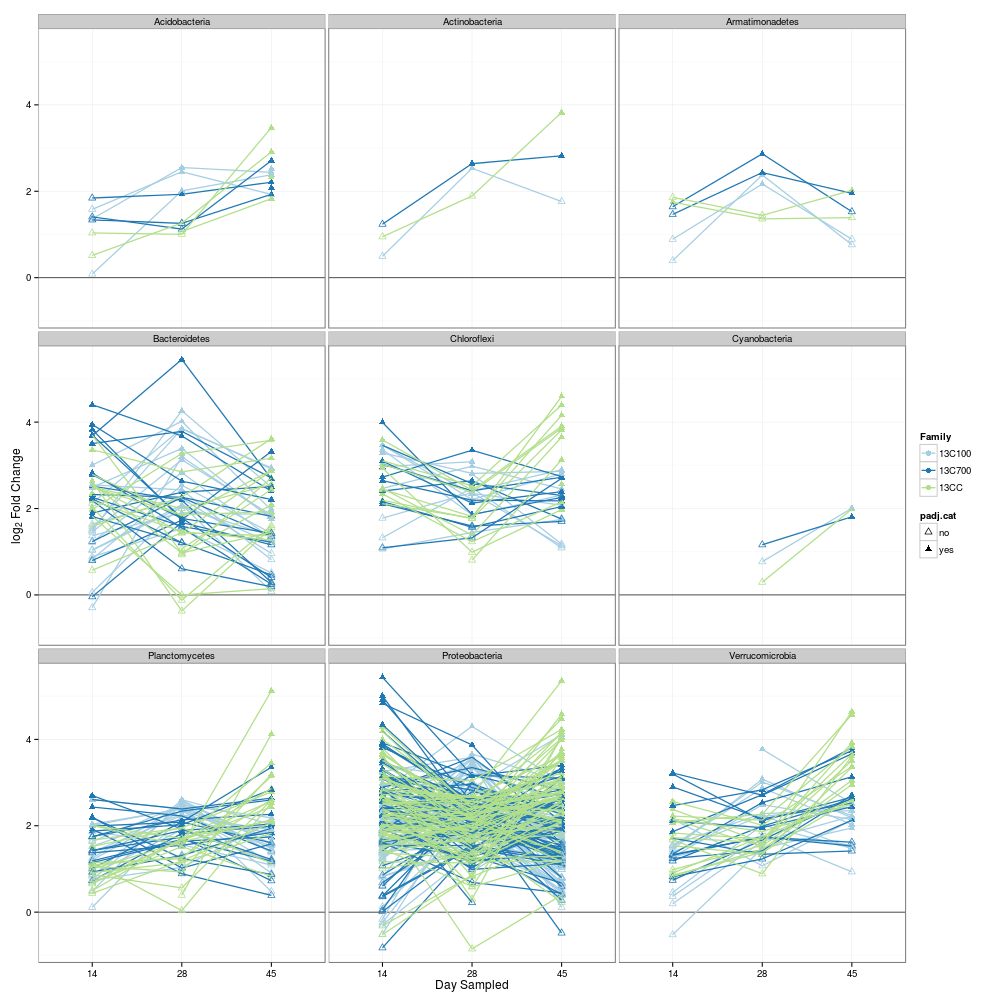

In [11]:
%%R -h 1000 -w 1000

colourCount = length(unique(shared.resp$Rank2))
getPalette = colorRampPalette(brewer.pal(colourCount, "Paired"))

p = ggplot(shared.resp, aes(x = factor(Day), y = log2FoldChange, group = interaction(OTU, Treatment), 
                            color = Treatment, shape = padj.cat))

p = p + geom_hline(y = 0, color = "grey20", size = 0.4)

p = p + geom_point(size = 2.5) 

p = p + geom_line(size = 0.6)

p = p + scale_shape_manual(values = c(2, 17))
#p = p + geom_point(data=p, mapping=aes(x=p%%16, y=p%/%16, shape=p), size=5, fill="red")

p = p + labs(x = "Day Sampled",
             y = expression(paste("", log[2], " Fold Change", sep = "")),
             color = "Family")

p = p + theme_bw()

p = p + scale_color_manual(values = getPalette(colourCount), na.value = "grey50")

p = p + facet_wrap(~Rank2)

p

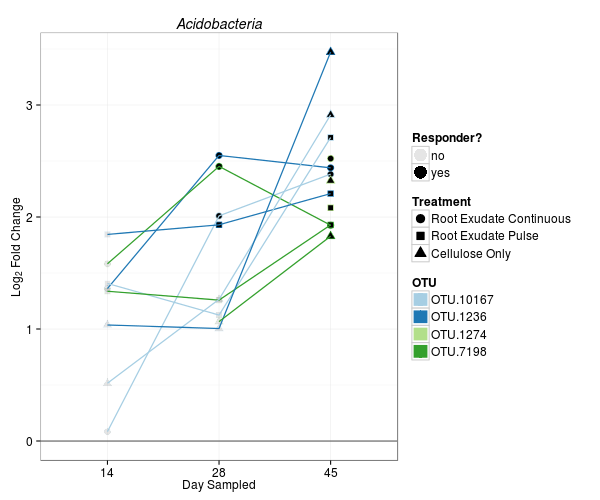

In [12]:
%%R -h 500 -w 600

shared.resp2 = shared.resp %>%
    filter(Rank2 == "Acidobacteria")
colourCount = length(unique(shared.resp2$OTU))
getPalette = colorRampPalette(brewer.pal(colourCount, "Paired"))

p2 = ggplot(shared.resp2, aes(x = factor(Day), y = log2FoldChange, group = interaction(OTU, Treatment), 
                            color = OTU, shape = Treatment))

p2 = p2 + geom_hline(y = 0, color = "grey20", size = 0.4)

p2 = p2 + geom_point(aes(alpha = padj.cat), fill = "black", size = 3) 

p2 = p2 + geom_line(size = 0.6)

#p2 = p2 + scale_fill_manual(values = c("yes" = "black",
#                                        "no" = "gainsboro"))

p2 = p2 + scale_alpha_manual(values = c(0.1, 1))


p2 = p2 + scale_shape_manual(values = c(21, 22, 24),
                            breaks=c("13C100", "13C700", "13CC"),
                            labels=c("Root Exudate Continuous", "Root Exudate Pulse", "Cellulose Only"))

p2 = p2 + labs(x = "Day Sampled",
             y = expression(paste("", Log[2], " Fold Change", sep = "")),
             color = "OTU",
             alpha = "Responder?",
             title = "Acidobacteria")

p2 = p2 + theme_bw()

p2 = p2 + theme(axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                plot.title = element_text(size = 14, face = "italic"),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12))

p2 = p2 + guides(color = guide_legend(override.aes = list(size = 6)))
p2 = p2 + guides(shape = guide_legend(override.aes = list(size = 4)))
p2 = p2 + guides(alpha = guide_legend(override.aes = list(size = 6)))

p2 = p2 + scale_color_manual(values = getPalette(colourCount), na.value = "grey50")

#p2 = p2 + facet_wrap(~Rank3)

p2

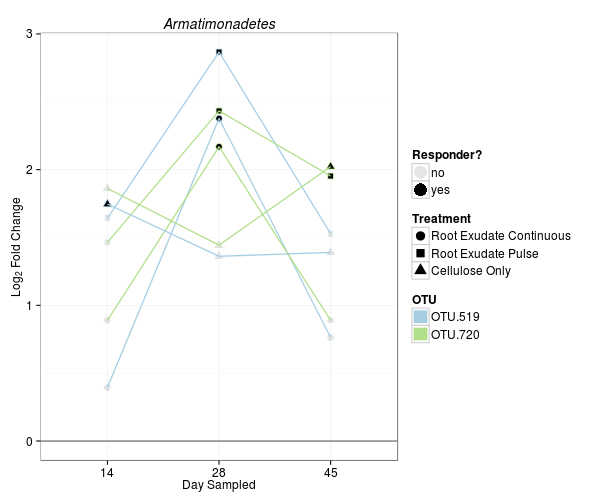

In [13]:
%%R -h 500 -w 600

shared.resp2 = shared.resp %>%
    filter(Rank2 == "Armatimonadetes")
colourCount = length(unique(shared.resp2$OTU))
getPalette = colorRampPalette(brewer.pal(colourCount, "Paired"))

p2 = ggplot(shared.resp2, aes(x = factor(Day), y = log2FoldChange, group = interaction(OTU, Treatment), 
                            color = OTU, shape = Treatment))

p2 = p2 + geom_hline(y = 0, color = "grey20", size = 0.4)

p2 = p2 + geom_point(aes(alpha = padj.cat), fill = "black", size = 3) 

p2 = p2 + geom_line(size = 0.6)

#p2 = p2 + scale_fill_manual(values = c("yes" = "black",
#                                        "no" = "gainsboro"))

p2 = p2 + scale_alpha_manual(values = c(0.1, 1))


p2 = p2 + scale_shape_manual(values = c(21, 22, 24),
                            breaks=c("13C100", "13C700", "13CC"),
                            labels=c("Root Exudate Continuous", "Root Exudate Pulse", "Cellulose Only"))

p2 = p2 + labs(x = "Day Sampled",
             y = expression(paste("", Log[2], " Fold Change", sep = "")),
             color = "OTU",
             alpha = "Responder?",
             title = "Armatimonadetes")

p2 = p2 + theme_bw()

p2 = p2 + theme(axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                plot.title = element_text(size = 14, face = "italic"),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12))

p2 = p2 + guides(color = guide_legend(override.aes = list(size = 6)))
p2 = p2 + guides(shape = guide_legend(override.aes = list(size = 4)))
p2 = p2 + guides(alpha = guide_legend(override.aes = list(size = 6)))

p2 = p2 + scale_color_manual(values = getPalette(colourCount), na.value = "grey50")

#p2 = p2 + facet_wrap(~Rank3)

p2

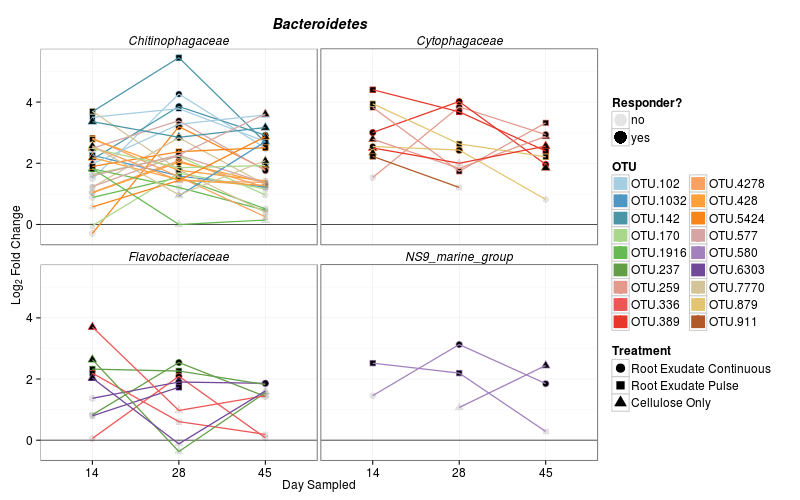

In [16]:
%%R -h 500 -w 800

shared.resp2 = shared.resp %>%
    filter(Rank2 == "Bacteroidetes")
colourCount = length(unique(shared.resp2$OTU))
getPalette = colorRampPalette(brewer.pal(colourCount, "Paired"))

p2 = ggplot(shared.resp2, aes(x = factor(Day), y = log2FoldChange, group = interaction(OTU, Treatment), 
                            color = OTU, shape = Treatment))

p2 = p2 + geom_hline(y = 0, color = "grey20", size = 0.4)

p2 = p2 + geom_point(aes(alpha = padj.cat), fill = "black", size = 3) 

p2 = p2 + geom_line(size = 0.6)

#p2 = p2 + scale_fill_manual(values = c("yes" = "black",
#                                        "no" = "gainsboro"))

p2 = p2 + scale_alpha_manual(values = c(0.1, 1))


p2 = p2 + scale_shape_manual(values = c(21, 22, 24),
                            breaks=c("13C100", "13C700", "13CC"),
                            labels=c("Root Exudate Continuous", "Root Exudate Pulse", "Cellulose Only"))

p2 = p2 + labs(x = "Day Sampled",
             y = expression(paste("", Log[2], " Fold Change", sep = "")),
             color = "OTU",
             alpha = "Responder?",
             title = "Bacteroidetes")

p2 = p2 + theme_bw()

p2 = p2 + theme(axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                plot.title = element_text(size = 14, face = "bold.italic"),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12),
                strip.background = element_blank(),
                strip.text = element_text(size = 12, face = "italic"))

p2 = p2 + guides(color = guide_legend(override.aes = list(size = 6), ncol = 2))
p2 = p2 + guides(shape = guide_legend(override.aes = list(size = 4)))
p2 = p2 + guides(alpha = guide_legend(override.aes = list(size = 6)))

p2 = p2 + scale_color_manual(values = getPalette(colourCount), na.value = "grey50")

p2 = p2 + facet_wrap(~Rank5)

p2

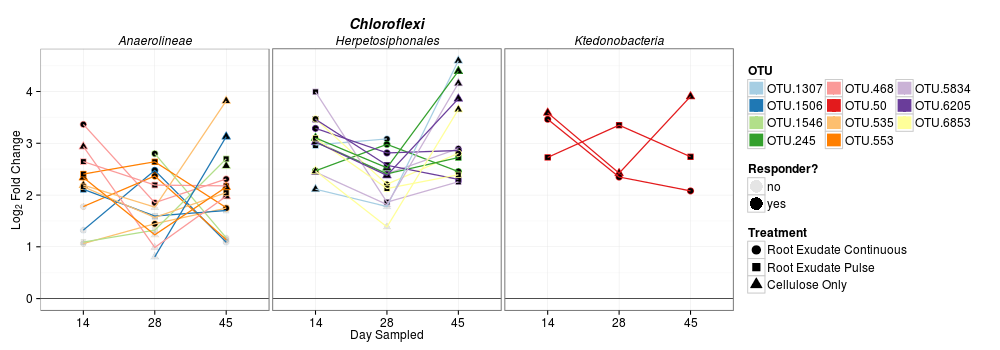

In [15]:
%%R -h 350 -w 1000

shared.resp2 = shared.resp %>%
    filter(Rank2 == "Chloroflexi")
colourCount = length(unique(shared.resp2$OTU))
getPalette = colorRampPalette(brewer.pal(colourCount, "Paired"))

p2 = ggplot(shared.resp2, aes(x = factor(Day), y = log2FoldChange, group = interaction(OTU, Treatment), 
                            color = OTU, shape = Treatment))

p2 = p2 + geom_hline(y = 0, color = "grey20", size = 0.4)

p2 = p2 + geom_point(aes(alpha = padj.cat), fill = "black", size = 3) 

p2 = p2 + geom_line(size = 0.6)

#p2 = p2 + scale_fill_manual(values = c("yes" = "black",
#                                        "no" = "gainsboro"))

p2 = p2 + scale_alpha_manual(values = c(0.1, 1))


p2 = p2 + scale_shape_manual(values = c(21, 22, 24),
                            breaks=c("13C100", "13C700", "13CC"),
                            labels=c("Root Exudate Continuous", "Root Exudate Pulse", "Cellulose Only"))

p2 = p2 + labs(x = "Day Sampled",
             y = expression(paste("", Log[2], " Fold Change", sep = "")),
             color = "OTU",
             alpha = "Responder?",
             title = "Chloroflexi")

p2 = p2 + theme_bw()

p2 = p2 + theme(axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                plot.title = element_text(size = 14, face = "bold.italic"),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12),
                strip.background = element_blank(),
                strip.text = element_text(size = 12, face = "italic"))

p2 = p2 + guides(color = guide_legend(override.aes = list(size = 6), ncol = 3))
p2 = p2 + guides(shape = guide_legend(override.aes = list(size = 4)))
p2 = p2 + guides(alpha = guide_legend(override.aes = list(size = 6)))

p2 = p2 + scale_color_manual(values = getPalette(colourCount), na.value = "grey50")

p2 = p2 + facet_wrap(~Rank3)

#p2 = p2 + guides(col = guide_legend(nrow = 11))

p2

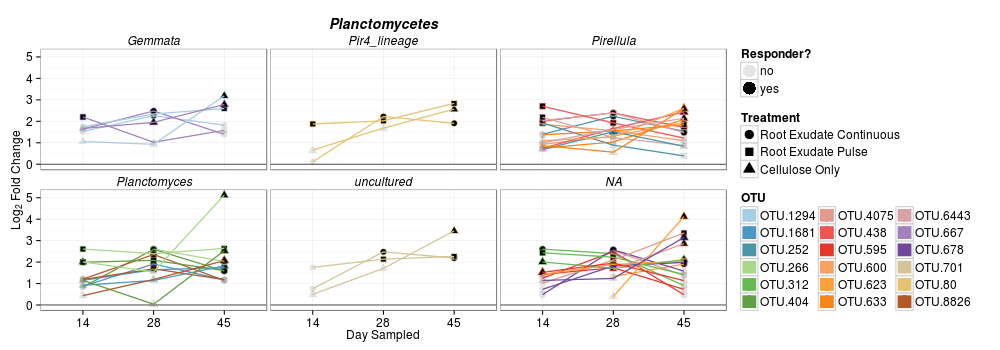

In [20]:
%%R -h 350 -w 1000

shared.resp2 = shared.resp %>%
    filter(Rank2 == "Planctomycetes")
colourCount = length(unique(shared.resp2$OTU))
getPalette = colorRampPalette(brewer.pal(colourCount, "Paired"))

p2 = ggplot(shared.resp2, aes(x = factor(Day), y = log2FoldChange, group = interaction(OTU, Treatment), 
                            color = OTU, shape = Treatment))

p2 = p2 + geom_hline(y = 0, color = "grey20", size = 0.4)

p2 = p2 + geom_point(aes(alpha = padj.cat), fill = "black", size = 3) 

p2 = p2 + geom_line(size = 0.6)

#p2 = p2 + scale_fill_manual(values = c("yes" = "black",
#                                        "no" = "gainsboro"))

p2 = p2 + scale_alpha_manual(values = c(0.1, 1))


p2 = p2 + scale_shape_manual(values = c(21, 22, 24),
                            breaks=c("13C100", "13C700", "13CC"),
                            labels=c("Root Exudate Continuous", "Root Exudate Pulse", "Cellulose Only"))

p2 = p2 + labs(x = "Day Sampled",
             y = expression(paste("", Log[2], " Fold Change", sep = "")),
             color = "OTU",
             alpha = "Responder?",
             title = "Planctomycetes")

p2 = p2 + theme_bw()

p2 = p2 + theme(axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                plot.title = element_text(size = 14, face = "bold.italic"),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12),
                strip.background = element_blank(),
                strip.text = element_text(size = 12, face = "italic"))

p2 = p2 + guides(color = guide_legend(override.aes = list(size = 6), ncol = 3))
p2 = p2 + guides(shape = guide_legend(override.aes = list(size = 4)))
p2 = p2 + guides(alpha = guide_legend(override.aes = list(size = 6)))

p2 = p2 + scale_color_manual(values = getPalette(colourCount), na.value = "grey50")

p2 = p2 + facet_wrap(~Rank6)

#p2 = p2 + guides(col = guide_legend(nrow = 11))

p2

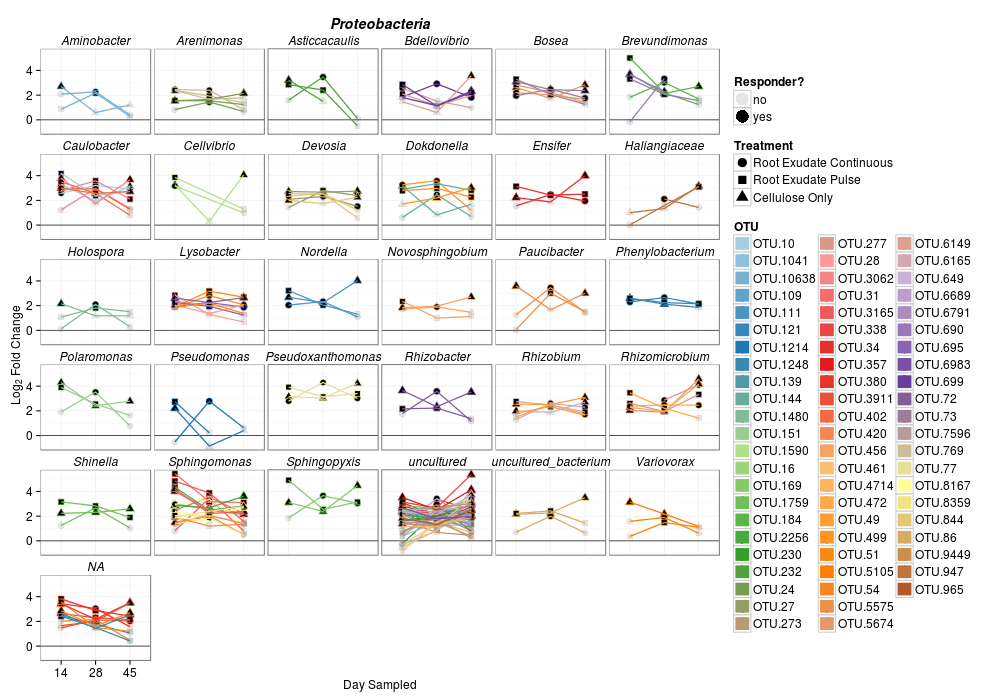

In [26]:
%%R -h 700 -w 1000

shared.resp2 = shared.resp %>%
    filter(Rank2 == "Proteobacteria")
colourCount = length(unique(shared.resp2$OTU))
getPalette = colorRampPalette(brewer.pal(colourCount, "Paired"))

p2 = ggplot(shared.resp2, aes(x = factor(Day), y = log2FoldChange, group = interaction(OTU, Treatment), 
                            color = OTU, shape = Treatment))

p2 = p2 + geom_hline(y = 0, color = "grey20", size = 0.4)

p2 = p2 + geom_point(aes(alpha = padj.cat), fill = "black", size = 3) 

p2 = p2 + geom_line(size = 0.6)

#p2 = p2 + scale_fill_manual(values = c("yes" = "black",
#                                        "no" = "gainsboro"))

p2 = p2 + scale_alpha_manual(values = c(0.1, 1))


p2 = p2 + scale_shape_manual(values = c(21, 22, 24),
                            breaks=c("13C100", "13C700", "13CC"),
                            labels=c("Root Exudate Continuous", "Root Exudate Pulse", "Cellulose Only"))

p2 = p2 + labs(x = "Day Sampled",
             y = expression(paste("", Log[2], " Fold Change", sep = "")),
             color = "OTU",
             alpha = "Responder?",
             title = "Proteobacteria")

p2 = p2 + theme_bw()

p2 = p2 + theme(axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                plot.title = element_text(size = 14, face = "bold.italic"),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12),
                strip.background = element_blank(),
                strip.text = element_text(size = 12, face = "italic"))

p2 = p2 + guides(color = guide_legend(override.aes = list(size = 6), ncol = 3))
p2 = p2 + guides(shape = guide_legend(override.aes = list(size = 4)))
p2 = p2 + guides(alpha = guide_legend(override.aes = list(size = 6)))

p2 = p2 + scale_color_manual(values = getPalette(colourCount), na.value = "grey50")

p2 = p2 + facet_wrap(~Rank6)

#p2 = p2 + guides(col = guide_legend(nrow = 11))

p2

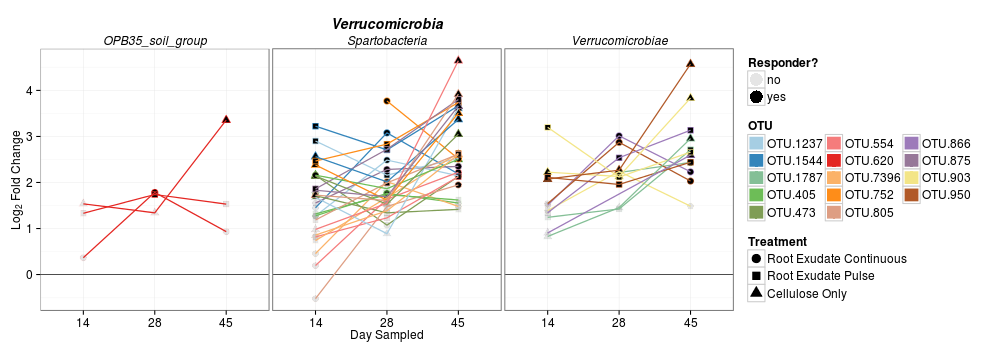

In [31]:
%%R -h 350 -w 1000

shared.resp2 = shared.resp %>%
    filter(Rank2 == "Verrucomicrobia")
colourCount = length(unique(shared.resp2$OTU))
getPalette = colorRampPalette(brewer.pal(colourCount, "Paired"))

p2 = ggplot(shared.resp2, aes(x = factor(Day), y = log2FoldChange, group = interaction(OTU, Treatment), 
                            color = OTU, shape = Treatment))

p2 = p2 + geom_hline(y = 0, color = "grey20", size = 0.4)

p2 = p2 + geom_point(aes(alpha = padj.cat), fill = "black", size = 3) 

p2 = p2 + geom_line(size = 0.6)

#p2 = p2 + scale_fill_manual(values = c("yes" = "black",
#                                        "no" = "gainsboro"))

p2 = p2 + scale_alpha_manual(values = c(0.1, 1))


p2 = p2 + scale_shape_manual(values = c(21, 22, 24),
                            breaks=c("13C100", "13C700", "13CC"),
                            labels=c("Root Exudate Continuous", "Root Exudate Pulse", "Cellulose Only"))

p2 = p2 + labs(x = "Day Sampled",
             y = expression(paste("", Log[2], " Fold Change", sep = "")),
             color = "OTU",
             alpha = "Responder?",
             title = "Verrucomicrobia")

p2 = p2 + theme_bw()

p2 = p2 + theme(axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                plot.title = element_text(size = 14, face = "bold.italic"),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12),
                strip.background = element_blank(),
                strip.text = element_text(size = 12, face = "italic"))

p2 = p2 + guides(color = guide_legend(override.aes = list(size = 6), ncol = 3))
p2 = p2 + guides(shape = guide_legend(override.aes = list(size = 4)))
p2 = p2 + guides(alpha = guide_legend(override.aes = list(size = 6)))

p2 = p2 + scale_color_manual(values = getPalette(colourCount), na.value = "grey50")

p2 = p2 + facet_wrap(~Rank3)

#p2 = p2 + guides(col = guide_legend(nrow = 11))

p2